In [9]:
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook
import os
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten,Dropout,LSTM

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import datetime
from datetime import date, timedelta
e_date = datetime.datetime.strptime('2020-06-20', '%Y-%m-%d')
i_date = datetime.datetime.strptime('2020-04-01', '%Y-%m-%d')

data_path = os.path.join('..','..','OD')

In [10]:
delta = e_date - i_date

target_days = []
for i in range(delta.days + 1):
    day = i_date + timedelta(days=i)
    target_days.append(day)

In [11]:
def read_OD_fn(source_type):
    ods = {}
    for date in tqdm_notebook(target_days):
        od_date= pd.read_csv(os.path.join(data_path, 'date_{}_OD_{}.csv'.format(source_type,date.strftime('%Y-%m-%d'))), 
                            index_col=0)
        ods[date] = od_date
    return ods

In [12]:
ine_ods = read_OD_fn('INE')

  0%|          | 0/81 [00:00<?, ?it/s]

In [13]:
twt_ods = read_OD_fn('TWT')

  0%|          | 0/81 [00:00<?, ?it/s]

# Serializar los datos

In [14]:
lista_twt = []

for date in tqdm_notebook(target_days):
    lista_twt.append(twt_ods[date].loc['total','total'])
    
del twt_ods
    
lista_ine = []

for date in tqdm_notebook(target_days):
    lista_ine.append(ine_ods[date].loc['total','total'])
    
del ine_ods

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

In [15]:
df_twt = pd.DataFrame (lista_twt, columns = ['Viajes'], index= target_days)
df_ine = pd.DataFrame (lista_ine, columns = ['Viajes'], index= target_days)

In [16]:
df_twt.head()

,Viajes
2020-04-01,2375
2020-04-02,2450
2020-04-03,2503
2020-04-04,554
2020-04-05,1319


# Visualización de datos

In [17]:
print(df_twt.index.min())
print(df_ine.index.max())

2020-04-01 00:00:00
2020-06-20 00:00:00


In [18]:
print(len(df_twt['2020']))

81


In [19]:
print(len(df_ine['2020']))

81


In [20]:
df_twt.describe()

,Viajes
count,81.000000
mean,2943.000000
std,887.069149
min,0.000000
25%,2363.000000
50%,2904.000000
75%,3629.000000
max,4738.000000


In [21]:
df_ine.describe()

,Viajes
count,8.100000e+01
mean,3.438222e+06
std,1.174931e+06
min,1.535886e+06
25%,2.488436e+06
50%,3.396402e+06
75%,4.445190e+06
max,5.519725e+06


In [22]:
meses = df_twt.resample('M').mean()
meses

,Viajes
2020-04-30,2157.500000
2020-05-31,3128.193548
2020-06-30,3834.200000


In [23]:
meses = df_ine.resample('M').mean()
meses

,Viajes
2020-04-30,2.356878e+06
2020-05-31,3.590722e+06
2020-06-30,4.823862e+06


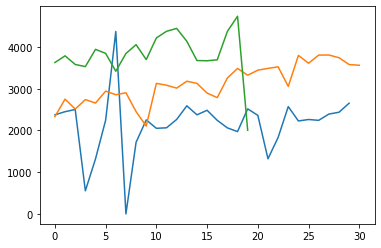

In [24]:
abril = df_twt['2020-04-01':'2020-04-30']
plt.plot(abril.values)
mayo = df_twt['2020-05-01':'2020-05-31']
plt.plot(mayo.values)
junio = df_twt['2020-06-01':'2020-06-20']
plt.plot(junio.values)

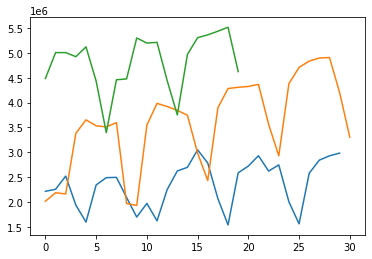

In [25]:
abril = df_ine['2020-04-01':'2020-04-30']
plt.plot(abril.values)
mayo = df_ine['2020-05-01':'2020-05-31']
plt.plot(mayo.values)
junio = df_ine['2020-06-01':'2020-06-20']
plt.plot(junio.values)

# Preprocesado de datos

In [26]:
dataset_twt = df_twt.values
dataset_twt = dataset_twt.astype('float32')

dataset_ine = df_ine.values
dataset_ine = dataset_ine.astype('float32')

In [27]:
# normalizamos el conjunto de datos
scaler = MinMaxScaler(feature_range=(0, 1))
dataset_twt = scaler.fit_transform(dataset_twt)
dataset_ine = scaler.fit_transform(dataset_ine)

# Dividimos los datos en sets de entrenamiento y validacion

In [28]:
#dividimos nuestros valores entre sets de entrenamiento y de test
n_train_days = 60
train_twt = dataset_twt[:n_train_days, :]
test_twt = dataset_twt[n_train_days:, :]

train_ine = dataset_ine[:n_train_days, :]
test_ine = dataset_ine[n_train_days:, :]

print(len(train_twt), len(test_twt))

60 21


In [29]:
# funcion para convertir un array de valores en una matriz de conjuntos de datos
def create_dataset(dataset1, dataset2, look_back=1):
  dataX, dataY = [], []
  for i in range(len(dataset2)-look_back):
    a = []
    for x in range(look_back):
        a.append(dataset2[i+x])  
        a.append(dataset1[i+x])
    a = np.array(a)
    a = np.reshape(a, (7, 1, 2))
    dataX.append(a)
    dataY.append(dataset2[i + look_back, 0])
  return np.array(dataX), np.array(dataY)

In [30]:
# dividimos en entradas y salidas
look_back = 7
trainX, trainY = create_dataset(train_twt, train_ine, look_back)
testX, testY = create_dataset(test_twt, test_ine, look_back)

print(len(trainX), len(testY))

53 14


In [31]:
print(trainX)

[[[[0.16999608 0.50126636]]

  [[0.18028718 0.5170958 ]]

  [[0.2470504  0.528282  ]]

  [[0.10007131 0.11692698]]

  [[0.01443306 0.27838752]]

  [[0.20226192 0.47425076]]

  [[0.23910356 0.9229633 ]]]


 [[[0.18028718 0.5170958 ]]

  [[0.2470504  0.528282  ]]

  [[0.10007131 0.11692698]]

  [[0.01443306 0.27838752]]

  [[0.20226192 0.47425076]]

  [[0.23910356 0.9229633 ]]

  [[0.24053836 0.        ]]]


 [[[0.2470504  0.528282  ]]

  [[0.10007131 0.11692698]]

  [[0.01443306 0.27838752]]

  [[0.20226192 0.47425076]]

  [[0.23910356 0.9229633 ]]

  [[0.24053836 0.        ]]

  [[0.1389401  0.3623892 ]]]


 [[[0.10007131 0.11692698]]

  [[0.01443306 0.27838752]]

  [[0.20226192 0.47425076]]

  [[0.23910356 0.9229633 ]]

  [[0.24053836 0.        ]]

  [[0.1389401  0.3623892 ]]

  [[0.03971621 0.4755171 ]]]


 [[[0.01443306 0.27838752]]

  [[0.20226192 0.47425076]]

  [[0.23910356 0.9229633 ]]

  [[0.24053836 0.        ]]

  [[0.1389401  0.3623892 ]]

  [[0.03971621 0.4755171 ]]

  [[0.

In [32]:
print(trainY)

[0.24053836 0.1389401  0.03971621 0.10891479 0.02047423 0.17865783
 0.27293295 0.2914425  0.37988257 0.313093   0.13297123 0.
 0.26343662 0.29775453 0.34997272 0.27233207 0.30363703 0.11689752
 0.00537395 0.26156402 0.32788748 0.3494845  0.36331165 0.11988008
 0.16276813 0.1565342  0.46347785 0.5314964  0.50147784 0.49586993
 0.51747626 0.10823756 0.09844148 0.5044481  0.61485875 0.59899086
 0.5796803  0.5546241  0.3633111  0.22455525 0.59261984 0.689921
 0.6962447  0.7003162  0.71110225 0.50901634 0.34968656 0.7144731
 0.7966052  0.82881963 0.8441757  0.8469062  0.6693162 ]


In [33]:
# remodelamos la entrada para que sea[muestras, pasos de tiempo, características]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 2))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 2))

In [34]:
print(trainX)

[[[0.16999608 0.50126636]
  [0.18028718 0.5170958 ]
  [0.2470504  0.528282  ]
  [0.10007131 0.11692698]
  [0.01443306 0.27838752]
  [0.20226192 0.47425076]
  [0.23910356 0.9229633 ]]

 [[0.18028718 0.5170958 ]
  [0.2470504  0.528282  ]
  [0.10007131 0.11692698]
  [0.01443306 0.27838752]
  [0.20226192 0.47425076]
  [0.23910356 0.9229633 ]
  [0.24053836 0.        ]]

 [[0.2470504  0.528282  ]
  [0.10007131 0.11692698]
  [0.01443306 0.27838752]
  [0.20226192 0.47425076]
  [0.23910356 0.9229633 ]
  [0.24053836 0.        ]
  [0.1389401  0.3623892 ]]

 [[0.10007131 0.11692698]
  [0.01443306 0.27838752]
  [0.20226192 0.47425076]
  [0.23910356 0.9229633 ]
  [0.24053836 0.        ]
  [0.1389401  0.3623892 ]
  [0.03971621 0.4755171 ]]

 [[0.01443306 0.27838752]
  [0.20226192 0.47425076]
  [0.23910356 0.9229633 ]
  [0.24053836 0.        ]
  [0.1389401  0.3623892 ]
  [0.03971621 0.4755171 ]
  [0.10891479 0.43309414]]

 [[0.20226192 0.47425076]
  [0.23910356 0.9229633 ]
  [0.24053836 0.        ]
  

In [35]:
print(trainY)

[0.24053836 0.1389401  0.03971621 0.10891479 0.02047423 0.17865783
 0.27293295 0.2914425  0.37988257 0.313093   0.13297123 0.
 0.26343662 0.29775453 0.34997272 0.27233207 0.30363703 0.11689752
 0.00537395 0.26156402 0.32788748 0.3494845  0.36331165 0.11988008
 0.16276813 0.1565342  0.46347785 0.5314964  0.50147784 0.49586993
 0.51747626 0.10823756 0.09844148 0.5044481  0.61485875 0.59899086
 0.5796803  0.5546241  0.3633111  0.22455525 0.59261984 0.689921
 0.6962447  0.7003162  0.71110225 0.50901634 0.34968656 0.7144731
 0.7966052  0.82881963 0.8441757  0.8469062  0.6693162 ]


# Creamos la red neuronal

In [38]:
look_back

7

In [40]:
testY

array([0.46701586, 0.73428094, 0.7385304 , 0.94570637, 0.91997826,
       0.92358553, 0.73027647, 0.556531  , 0.86281145, 0.9470762 ,
       0.96157455, 0.9798436 , 1.        , 0.7757994 ], dtype=float32)

In [36]:
def crear_modeloFF():
    model = Sequential() 
    model.add(LSTM(20, input_shape=(look_back,2), return_sequences=True))
    model.add(LSTM(50, input_shape=(look_back,2), return_sequences=True))
    model.add(Dropout(0.30))
    model.add(LSTM(100, input_shape=(look_back,2)))
    model.add(Dropout(0.30))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.summary()
    return model

In [37]:
model = crear_modeloFF()

history=model.fit(trainX, trainY, epochs=200, validation_data=(testX,testY), batch_size=1, verbose=2)

NotImplementedError: Cannot convert a symbolic Tensor (lstm/strided_slice:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported

# Visualizamos resultados

In [ ]:
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100


def compute_metrics_fn(y_valid_resc, y_hat_resc):
    mae_ = mean_absolute_error(y_valid_resc, y_hat_resc)
    mse_ = mean_squared_error(y_valid_resc, y_hat_resc)
    rmse_ = mean_squared_error(y_valid_resc, y_hat_resc, squared = False)
    cvrmse_ = rmse_/np.mean(y_valid_resc)*100 # it is a percentage
    mape_ = mape(y_valid_resc, y_hat_resc)
    
    return mae_, mse_, rmse_, cvrmse_, mape_

In [ ]:
# hacemos las predicciones
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# invertimos las predicciones
trainPredict = scaler.inverse_transform(trainPredict)
trainY_scalerInverse = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY_scalerInverse = scaler.inverse_transform([testY])

In [ ]:
# calculamos las metricas de error
trainScore_MAE, trainScore_MSE, trainScore_RMSE, trainScore_CVRMSE, trainScore_MAPE  =  compute_metrics_fn(trainY_scalerInverse[0], trainPredict[:,0])
print('Resultado del entrenamiento: %.2f MAE' % (trainScore_MAE))
print('Resultado del entrenamiento: %.2f MSE' % (trainScore_MSE))
print('Resultado del entrenamiento: %.2f RMSE' % (trainScore_RMSE))
print('Resultado del entrenamiento: %.2f CVRMSE' % (trainScore_CVRMSE))
print('Resultado del entrenamiento: %.2f MAPE \n' % (trainScore_MAPE))

testScore_MAE, testScore_MSE, testScore_RMSE, testScore_CVRMSE, testScore_MAPE  =  compute_metrics_fn(testY_scalerInverse[0], testPredict[:,0])
print('Resultado del test: %.2f MAE' % (testScore_MAE))
print('Resultado del test: %.2f MSE' % (testScore_MSE))
print('Resultado del test: %.2f RMSE' % (testScore_RMSE))
print('Resultado del test: %.2f CVRMSE' % (testScore_CVRMSE))
print('Resultado del test: %.2f MAPE' % (testScore_MAPE))

In [ ]:
plt.plot(df_ine.values)
plt.grid(True)
plt.title("Viajes totales según el INE", fontsize = 15)
plt.xlabel("Tiempo (dias)", fontsize = 10)
plt.ylabel("viajes", fontsize = 10)
plt.show()

In [ ]:
plt.plot(df_twt.values)
plt.grid(True)
plt.title("Viajes totales según TWT", fontsize = 15)
plt.xlabel("Tiempo (dias)", fontsize = 10)
plt.ylabel("viajes", fontsize = 10)
plt.show()

In [ ]:
# predicciones del entrenamiento de cambio para plotear
trainPredictPlot = np.empty_like(dataset_ine)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# predicciones del test de cambio para plotear
testPredictPlot = np.empty_like(dataset_ine)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2):len(dataset_ine), :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset_ine))
# ploteamos linea base y predicciones
plt.plot(trainPredictPlot,'r', linewidth = 2)
plt.plot(testPredictPlot,'m', linewidth = 2)
plt.legend( ('Datos', 'Prediccion datos entramiento', 'Prediccion sobre los datos de test'), loc = 'upper left')
plt.grid(True)
plt.title("Viajes totales", fontsize = 15)
plt.xlabel("Tiempo (dias)", fontsize = 10)
plt.ylabel("viajes", fontsize = 10)
plt.show()

In [ ]:
results=testPredict
print(len(results))

In [ ]:
test = testY_scalerInverse[0]

In [ ]:
plt.scatter(range(len(test)),test,c='g')
plt.scatter(range(len(results)),results,c='r')
plt.title('validate')
plt.show()

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('loss')
plt.legend( ('training loss', 'validate loss'), loc = 'upper right')
plt.show()

In [ ]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$"):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bx", markersize=10)
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "ro")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])

In [ ]:
n_steps = 6
plot_series(testX[0, :, 0], testY_scalerInverse[0, 0], testPredict[0, 0])
plt.show()

# Exportar los datos

In [ ]:
e_date = datetime.datetime.strptime('2020-06-20', '%Y-%m-%d')
i_date = datetime.datetime.strptime('2020-06-07', '%Y-%m-%d')
delta = e_date - i_date

index_days = []
for i in range(delta.days + 1):
    day = i_date + timedelta(days=i)
    index_days.append(day)

prediccion = pd.DataFrame(testPredict, index= index_days)
prediccion.columns = ['valor predicho']

prediccion

In [ ]:
datosReales = df_ine['2020-6-07':'2020-6-20']

compara = pd.concat([datosReales, prediccion], axis=1)
compara.columns = ['real', 'prediccion']

compara

In [ ]:
compara.to_excel('Resultados INE - TWT.xlsx', columns=['real', 'prediccion'])

# Prediccion a futuro

In [ ]:
# usaremos 7 dias que poseemos para predecir los 7 dias siguientes tras esto compararemos los resultados con los que
# poseemos para ver el grado de error

Dias_twt = df_twt['2020-5-18':'2020-5-24']
Dias_ine = df_ine['2020-5-18':'2020-5-24']

In [ ]:
# funcion para convertir un array de valores en una matriz de conjuntos de datos, en este caso modificada para ayudarnos a crear
#los distintos sets de entrenmiento para distintos modelos que predeciran 1 dia cada uno

def create_dataset2(dataset1, dataset2, look_back=1, dias=0):
  dataX, dataY = [], []
  for i in range(len(dataset2)-look_back-dias):
    a = []
    for x in range(look_back):
        a.append(dataset2[i+x])  
        a.append(dataset1[i+x])
    a = np.array(a)
    a = np.reshape(a, (7, 1, 2))
    dataX.append(a)
    dataY.append(dataset2[i + look_back + dias, 0])
  return np.array(dataX), np.array(dataY)

In [ ]:
#ahora crearemos los sets para entrenar los modelos
look_back = 7

trainX1, trainY1 = create_dataset2(train_twt, train_ine, look_back, 1)
testX1, testY1 = create_dataset2(test_twt, test_ine, look_back, 1)

trainX2, trainY2 = create_dataset2(train_twt, train_ine, look_back, 2)
testX2, testY2 = create_dataset2(test_twt, test_ine, look_back, 2)

trainX3, trainY3 = create_dataset2(train_twt, train_ine, look_back, 3)
testX3, testY3 = create_dataset2(test_twt, test_ine, look_back, 3)

trainX4, trainY4 = create_dataset2(train_twt, train_ine, look_back, 4)
testX4, testY4 = create_dataset2(test_twt, test_ine, look_back, 4)

trainX5, trainY5 = create_dataset2(train_twt, train_ine, look_back, 5)
testX5, testY5 = create_dataset2(test_twt, test_ine, look_back, 5)

trainX6, trainY6 = create_dataset2(train_twt, train_ine, look_back, 6)
testX6, testY6 = create_dataset2(test_twt, test_ine, look_back, 6)

In [ ]:
print(trainX1)

In [ ]:
print(trainY1)

In [ ]:
# remodelamos la entrada para que sea[muestras, pasos de tiempo, características]

trainX1 = np.reshape(trainX1, (trainX1.shape[0], trainX1.shape[1], 2))
testX1 = np.reshape(testX1, (testX1.shape[0], testX1.shape[1], 2))

trainX2 = np.reshape(trainX2, (trainX2.shape[0], trainX2.shape[1], 2))
testX2 = np.reshape(testX2, (testX2.shape[0], testX2.shape[1], 2))

trainX3 = np.reshape(trainX3, (trainX3.shape[0], trainX3.shape[1], 2))
testX3 = np.reshape(testX3, (testX3.shape[0], testX3.shape[1], 2))

trainX4 = np.reshape(trainX4, (trainX4.shape[0], trainX4.shape[1], 2))
testX4 = np.reshape(testX4, (testX4.shape[0], testX4.shape[1], 2))

trainX5 = np.reshape(trainX5, (trainX5.shape[0], trainX5.shape[1], 2))
testX5 = np.reshape(testX5, (testX5.shape[0], testX5.shape[1], 2))

trainX6 = np.reshape(trainX6, (trainX6.shape[0], trainX6.shape[1], 2))
testX6 = np.reshape(testX6, (testX6.shape[0], testX6.shape[1], 2))

In [ ]:
#creamos los distintos modelos para predecir cada dia

model1 = crear_modeloFF()
history=model1.fit(trainX1, trainY1, epochs=200, validation_data=(testX1,testY1), batch_size=1, verbose=2)

model2 = crear_modeloFF()
history=model2.fit(trainX2, trainY2, epochs=200, validation_data=(testX2,testY2), batch_size=1, verbose=2)

model3 = crear_modeloFF()
history=model3.fit(trainX3, trainY3, epochs=200, validation_data=(testX3,testY3), batch_size=1, verbose=2)

model4 = crear_modeloFF()
history=model4.fit(trainX4, trainY4, epochs=200, validation_data=(testX4,testY4), batch_size=1, verbose=2)

model5 = crear_modeloFF()
history=model5.fit(trainX5, trainY5, epochs=200, validation_data=(testX5,testY5), batch_size=1, verbose=2)

model6 = crear_modeloFF()
history=model6.fit(trainX6, trainY6, epochs=200, validation_data=(testX6,testY6), batch_size=1, verbose=2)

# Preparamos los datos para el test

In [ ]:
# cargamos el dataframe en la variable dataset
dataset_twt = Dias_twt.values
dataset_ine = Dias_ine.values

# convertimos los enteros en floats
dataset_twt = dataset_twt.astype('float32')
dataset_ine = dataset_ine.astype('float32')

# normalizamos los datos
scaler = MinMaxScaler(feature_range=(0, 1))
dataset_twt = scaler.fit_transform(dataset_twt)
dataset_ine = scaler.fit_transform(dataset_ine)

In [ ]:
# funcion para convertir un array de valores en una matriz de conjuntos de datos
def create_dataset3(dataset1, dataset2):
  dataX = []
  for x in range(len(dataset2)):
    dataX.append(dataset2[x])  
    dataX.append(dataset1[x])
  dataX = np.array(dataX)
  dataX = np.reshape(dataX, (7, 1, 2))
  return np.array(dataX)

In [ ]:
# usamos la funcion definida previamente para crear el dataset
testX = create_dataset3(dataset_twt, dataset_ine)

In [ ]:
#remodelamos los datos
testX = np.reshape(testX, (1, 7, 2))

# Realizamos la prediccion 

In [ ]:
results = []

parcial=model.predict(testX)
results.append(parcial[0])

parcial=model1.predict(testX)
results.append(parcial[0])

parcial=model2.predict(testX)
results.append(parcial[0])

parcial=model3.predict(testX)
results.append(parcial[0])

parcial=model4.predict(testX)
results.append(parcial[0])

parcial=model5.predict(testX)
results.append(parcial[0])

parcial=model6.predict(testX)
results.append(parcial[0])

results = np.reshape(results, (7, 1))
print(results)

# Re-Convertimos los resultados

In [ ]:
inverted = scaler.inverse_transform(results)

#en nuestro problema no tienen sentido los decimales pues no se pueden hacer 0.5 viajes o 0.25 viajes
inverted = inverted.round()
inverted = inverted.astype(int)

inverted

# Visualizamos el pronostico

In [ ]:
e_date = datetime.datetime.strptime('2020-05-31', '%Y-%m-%d')
i_date = datetime.datetime.strptime('2020-05-25', '%Y-%m-%d')
delta = e_date - i_date

index_days = []
for i in range(delta.days + 1):
    day = i_date + timedelta(days=i)
    index_days.append(day)

prediccion = pd.DataFrame(inverted, index= index_days)
prediccion.columns = ['pronostico']
prediccion.plot()

In [ ]:
datosReales = df_ine['2020-5-25':'2020-5-31']

compara = pd.concat([datosReales, prediccion], axis=1)
compara.columns = ['real', 'prediccion']
compara

In [ ]:
compara['real'].plot()
compara['prediccion'].plot()
plt.xlabel("Tiempo (dias)", fontsize = 10)
plt.ylabel("viajes", fontsize = 10)
plt.legend( ('Datos reales', 'Prediccion'), loc = 'lower right')

In [ ]:
# calculamos las metricas de error
testScore_MAE, testScore_MSE, testScore_RMSE, testScore_CVRMSE, testScore_MAPE  =  compute_metrics_fn(prediccion, datosReales)
print('Resultado del test: %.2f MAE' % (testScore_MAE))
print('Resultado del test: %.2f MSE' % (testScore_MSE))
print('Resultado del test: %.2f RMSE' % (testScore_RMSE))
print('Resultado del test: %.2f CVRMSE' % (testScore_CVRMSE))
print('Resultado del test: %.2f MAPE' % (testScore_MAPE))

In [ ]:
prediccion.values

In [ ]:
# calculamos las metricas de error para cada dia por separado
for i in range(7):
    testScore_MAE, testScore_MSE, testScore_RMSE, testScore_CVRMSE, testScore_MAPE  =  compute_metrics_fn(prediccion.values[i], datosReales.values[i])
    day = i + 1
    print('Resultado del test dia %d: %.2f MAE' % (day, testScore_MAE))
    print('Resultado del test dia %d: %.2f MSE' % (day, testScore_MSE))
    print('Resultado del test dia %d: %.2f RMSE' % (day, testScore_RMSE))
    print('Resultado del test dia %d: %.2f CVRMSE' % (day, testScore_CVRMSE))
    print('Resultado del test dia %d: %.2f MAPE \n' % (day, testScore_MAPE))